In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, precision_recall_curve, auc)
import seaborn as sns

In [2]:
# 1. 加载数据（假设文件名为creditcard.csv）
df = pd.read_csv('../data/creditcard.csv')

# 2. 检查数据分布
print("数据分布：\n", df['Class'].value_counts())
print("\n正例占比：{:.4f}%".format(df['Class'].mean() * 100))

# 3. 标准化Time和Amount（其他特征V1-V28已由PCA处理，无需标准化）
scaler = StandardScaler()
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# 4. 分离特征和标签
X = df.drop('Class', axis=1)
y = df['Class']

# 5. 分割数据集（保持类别比例）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

数据分布：
 Class
0    284315
1       492
Name: count, dtype: int64

正例占比：0.1727%


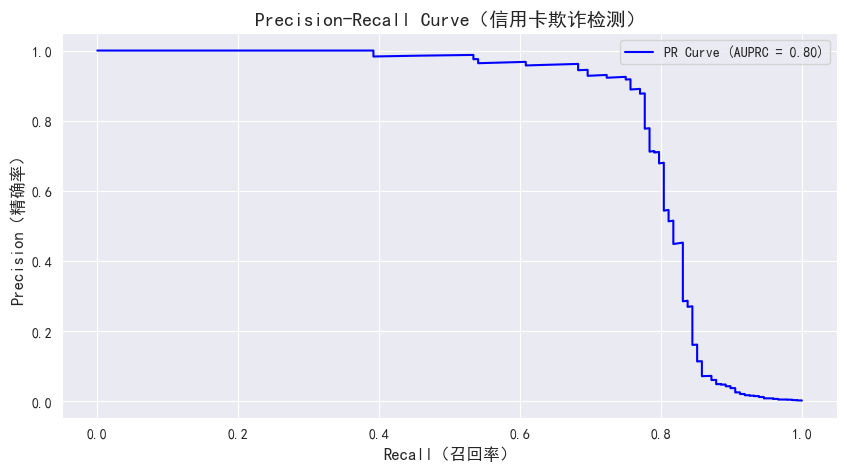

In [3]:
# 6. 训练BP神经网络（使用类别权重平衡数据）
model = MLPClassifier(
    random_state=123,
)
model.fit(X_train, y_train)

# 7. 预测概率（用于AUPRC和ROC-AUC）
y_prob = model.predict_proba(X_test)[:, 1]

# 8. 计算AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auprc = auc(recall, precision)

# 9. 绘制PR曲线
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label=f'PR Curve (AUPRC = {auprc:.2f})', color='blue')
plt.xlabel('Recall（召回率）', fontsize=12)
plt.ylabel('Precision（精确率）', fontsize=12)
plt.title('Precision-Recall Curve（信用卡欺诈检测）', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### **1. 结果解读**
#### **(1) AUPRC=0.80 的含义**
- **AUPRC（Area Under PR Curve）** 衡量的是模型在不同召回率下的平均精确率。
- **参考标准**：
  - **AUPRC > 0.9**：极佳（完美模型为1.0）。
  - **AUPRC ∈ [0.7, 0.9]**：良好，但需优化少数类（欺诈）识别。
  - **AUPRC < 0.7**：需显著改进。
- **你的结果（0.80）**：属于良好范围，但仍有提升空间（尤其是高召回率区域）。

#### **(2) 曲线形状分析**
- **理想情况**：曲线应尽量靠近右上角（高精确率+高召回率）。
- **你的曲线**：
  - 当召回率（Recall）> 0.6 时，精确率（Precision）明显下降。
  - 说明模型在检测更多欺诈交易（高召回率）时，误报率（False Positive）会显著增加。
